In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd
import numpy as np  
import sys

## Spatially and temporally varying interventions

Differences in the time required for an apoptotic agent to bring about cell death in our model are accounted for by how long signals from the affected nodes and edges of the internal regulatory network take to propogate to the apoptosis node. This signal delay also plays a role in the time required for a cell that has only partially committed to apoptosis to recover once the apoptotic substrate is removed. These two lag effects can combine in counterintuitive ways under periodic dosing. Fast interventions that initially appear to be more effective can fall behind slower interventions that initially kill fewer cells.

(lets describe the simulation eventually. For example, this exepriment includes a range of clearances)

### Load and process live cell data

This model includes only one population - so we extracted the live cells from each simulation time output. This data was placed in a CSV file. 

Here we load this into a dataframe, (no mean here) and finally plot all time courses. 

In [2]:
df_raw = pd.read_csv('../dataframes/aggregated_live_cells_time_and_space.csv', index_col=0)
df_raw.head()

,0.0,12.0,24.0,36.0,48.0,60.0,72.0,84.0,96.0,108.0,...,8532.0,8544.0,8556.0,8568.0,8580.0,8592.0,8604.0,8616.0,8628.0,8640.0
intervention,,,,,,,,,,,,,,,,,,,,,
EG_Ceramide_S1P_1_11,1344,1345,1349,1353,1353,1356,1358,1359,1361,1361,...,1601,1601,1601,1602,1603,1604,1604,1604,1604,1604
EG_Ceramide_S1P_1_21,1344,1345,1345,1347,1347,1350,1351,1352,1355,1356,...,1237,1237,1237,1237,1237,1237,1237,1237,1237,1238
EG_Ceramide_S1P_1_31,1344,1347,1348,1349,1350,1355,1355,1355,1359,1360,...,824,825,825,825,825,825,825,825,825,825
EG_GAP_RAS_1_11,1344,1346,1348,1351,1352,1352,1353,1355,1360,1362,...,1719,1719,1721,1721,1721,1722,1723,1723,1723,1723
EG_GAP_RAS_1_21,1344,1345,1348,1350,1350,1352,1354,1355,1355,1357,...,1272,1272,1272,1273,1273,1274,1274,1274,1274,1275


We will mainly be using the transpose of `raw` so lets transpose it. 

In [3]:
df = df_raw.transpose()
df.head(100)

intervention,EG_Ceramide_S1P_1_11,EG_Ceramide_S1P_1_21,EG_Ceramide_S1P_1_31,EG_GAP_RAS_1_11,EG_GAP_RAS_1_21,EG_GAP_RAS_1_31,EG_IL15_GAP_0_11,EG_IL15_GAP_0_21,EG_IL15_GAP_0_31,EG_IL2RBT_IL2RB_0_11,...,SM_pro_Ceramidepro_PI3Kpro_ERK_31,SM_pro_Ceramidepro_PI3Kpro_MEK_11,SM_pro_Ceramidepro_PI3Kpro_MEK_21,SM_pro_Ceramidepro_PI3Kpro_MEK_31,SM_pro_Ceramidepro_RAS_11,SM_pro_Ceramidepro_RAS_21,SM_pro_Ceramidepro_RAS_31,SM_pro_TBETpro_Ceramidepro_ERK_11,SM_pro_TBETpro_Ceramidepro_ERK_21,SM_pro_TBETpro_Ceramidepro_ERK_31
0.0,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,...,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
12.0,1345,1345,1347,1346,1345,1345,1345,1345,1348,1345,...,1345,1348,1347,1346,1344,1344,1347,1345,1344,1345
24.0,1349,1345,1348,1348,1348,1346,1346,1345,1349,1347,...,1347,1351,1349,1348,1346,1346,1348,1347,1347,1345
36.0,1353,1347,1349,1351,1350,1347,1349,1345,1351,1349,...,1348,1354,1350,1349,1345,1347,1349,1348,1348,1349
48.0,1353,1347,1350,1352,1350,1348,1352,1350,1351,1351,...,1348,1355,1352,1351,1345,1347,1349,1349,1350,1349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140.0,1419,1136,1031,1481,1289,1124,1466,1261,1101,1466,...,1021,1402,1129,1008,1395,1114,1027,773,765,767
1152.0,1420,1139,1031,1483,1289,1126,1467,1261,1101,1469,...,1022,1408,1129,1010,1395,1115,1027,773,765,767
1164.0,1420,1140,1031,1484,1290,1127,1467,1262,1100,1469,...,1025,1410,1129,1010,1398,1115,1029,773,765,768
1176.0,1423,1142,1032,1486,1290,1128,1470,1266,1102,1472,...,1025,1411,1129,1012,1398,1116,1029,775,767,769


Now we have something to plot! Lets chck them out!!

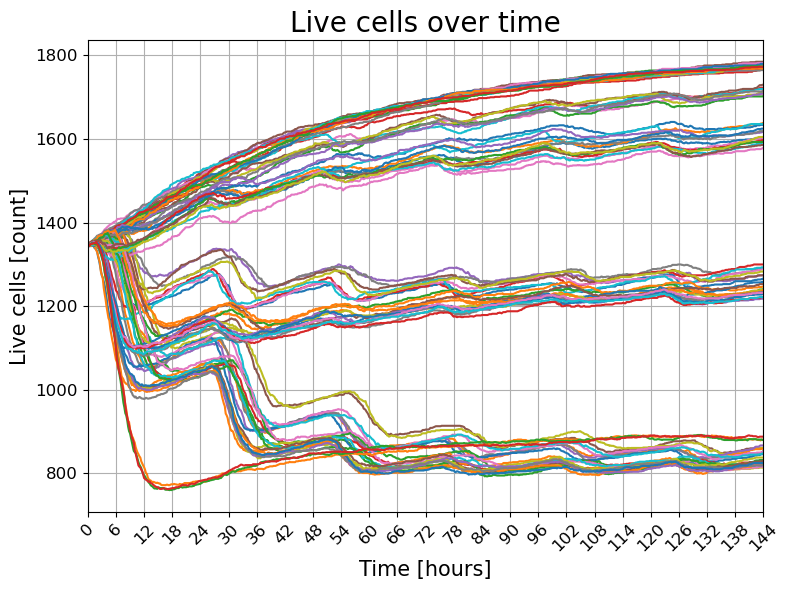

In [4]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

for intervention in df:
    plt.plot(df.index, df[intervention])

plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
# plt.ylim(0, 3200)
plt.xlim(0, df.index[-1])
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))
plt.tight_layout()
plt.savefig('../figures/spatial__and_time_all_time_courses.png', dpi=600)
plt.show()

### Add in the pulses

These simulations include concentrations that vary over time. So, we will include just the time when pulses restart. It is worth noting that at the slower clearance rates (the boundary condition takes longer to reach a 0 value), there is accumulation - so later pulses have more time/space above the activation threshold. 

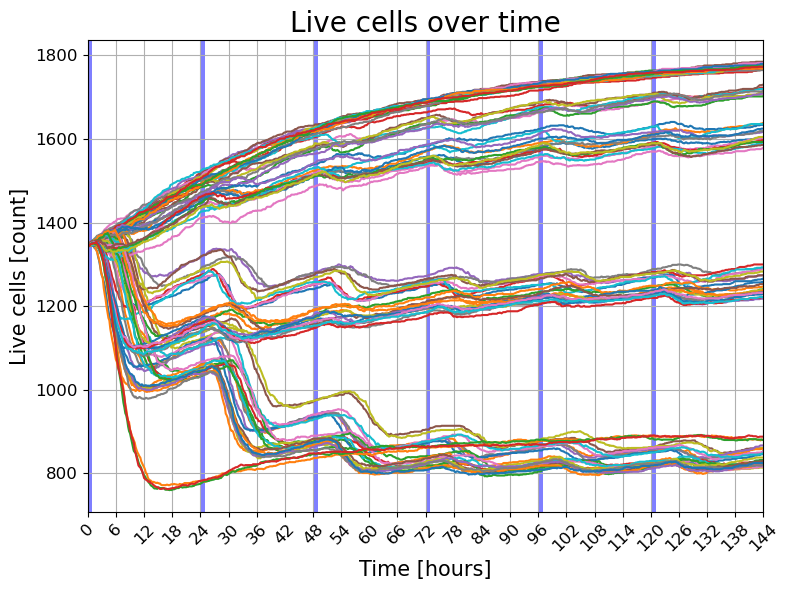

In [5]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

for intervention in df:
    plt.plot(df.index, df[intervention])

plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
# plt.ylim(0, 3200)
plt.xlim(0, df.index[-1])
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='major')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

# put these in a loop to color code the different time periods - every 24 hours.
for tick in ticks[0::4]:
    plt.axvspan(tick, tick+5, facecolor='blue', alpha=0.5, linewidth=6)


plt.tight_layout()
plt.savefig('../figures/spatial__and_time_all_time_courses.png', dpi=600)
plt.show()



### Lets break this down by scenario - looking for patterns and generally making the data more seeable

In the pulsed interveal analysis, we broke the data down several ways. Lets start here though by just breaking it down completely - making an array of each kind of simulation:
- Fast, medium, or slow clearance
- Edgetic, IBMFA, and stable motif target control algorithm



In [6]:
# Alter the dataframe - remove the last digit from the column names

column_remapped = [x[:-1] for x in df.columns]
df.columns = column_remapped

print(df.shape)
df.head()

(721, 84)


,EG_Ceramide_S1P_1_1,EG_Ceramide_S1P_1_2,EG_Ceramide_S1P_1_3,EG_GAP_RAS_1_1,EG_GAP_RAS_1_2,EG_GAP_RAS_1_3,EG_IL15_GAP_0_1,EG_IL15_GAP_0_2,EG_IL15_GAP_0_3,EG_IL2RBT_IL2RB_0_1,...,SM_pro_Ceramidepro_PI3Kpro_ERK_3,SM_pro_Ceramidepro_PI3Kpro_MEK_1,SM_pro_Ceramidepro_PI3Kpro_MEK_2,SM_pro_Ceramidepro_PI3Kpro_MEK_3,SM_pro_Ceramidepro_RAS_1,SM_pro_Ceramidepro_RAS_2,SM_pro_Ceramidepro_RAS_3,SM_pro_TBETpro_Ceramidepro_ERK_1,SM_pro_TBETpro_Ceramidepro_ERK_2,SM_pro_TBETpro_Ceramidepro_ERK_3
0.0,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,...,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
12.0,1345,1345,1347,1346,1345,1345,1345,1345,1348,1345,...,1345,1348,1347,1346,1344,1344,1347,1345,1344,1345
24.0,1349,1345,1348,1348,1348,1346,1346,1345,1349,1347,...,1347,1351,1349,1348,1346,1346,1348,1347,1347,1345
36.0,1353,1347,1349,1351,1350,1347,1349,1345,1351,1349,...,1348,1354,1350,1349,1345,1347,1349,1348,1348,1349
48.0,1353,1347,1350,1352,1350,1348,1352,1350,1351,1351,...,1348,1355,1352,1351,1345,1347,1349,1349,1350,1349


In [7]:
df_transpose = df.transpose()
df_transpose.head()

,0.0,12.0,24.0,36.0,48.0,60.0,72.0,84.0,96.0,108.0,...,8532.0,8544.0,8556.0,8568.0,8580.0,8592.0,8604.0,8616.0,8628.0,8640.0
EG_Ceramide_S1P_1_1,1344,1345,1349,1353,1353,1356,1358,1359,1361,1361,...,1601,1601,1601,1602,1603,1604,1604,1604,1604,1604
EG_Ceramide_S1P_1_2,1344,1345,1345,1347,1347,1350,1351,1352,1355,1356,...,1237,1237,1237,1237,1237,1237,1237,1237,1237,1238
EG_Ceramide_S1P_1_3,1344,1347,1348,1349,1350,1355,1355,1355,1359,1360,...,824,825,825,825,825,825,825,825,825,825
EG_GAP_RAS_1_1,1344,1346,1348,1351,1352,1352,1353,1355,1360,1362,...,1719,1719,1721,1721,1721,1722,1723,1723,1723,1723
EG_GAP_RAS_1_2,1344,1345,1348,1350,1350,1352,1354,1355,1355,1357,...,1272,1272,1272,1273,1273,1274,1274,1274,1274,1275


Make categories dataframe - getting the algorithm and decay

In [8]:
df_categories = pd.DataFrame(index=df_transpose.index)

for index in df_transpose.index:
    split_index = index.split('_', 10)
    df_categories.loc[index, 'algorithm'] = split_index[0]
    df_categories.loc[index, 'decay'] = split_index[-1]
    # df_temp.loc[index, 'type'] = split_index[-2] # this would involve string matching to really do right (pro = 1, anti=0)


df_categories

,algorithm,decay
EG_Ceramide_S1P_1_1,EG,1
EG_Ceramide_S1P_1_2,EG,2
EG_Ceramide_S1P_1_3,EG,3
EG_GAP_RAS_1_1,EG,1
EG_GAP_RAS_1_2,EG,2
...,...,...
SM_pro_Ceramidepro_RAS_2,SM,2
SM_pro_Ceramidepro_RAS_3,SM,3
SM_pro_TBETpro_Ceramidepro_ERK_1,SM,1
SM_pro_TBETpro_Ceramidepro_ERK_2,SM,2


Remember - here we are jsut going with the complete break down first. So they are split out into each indvidual category.

In [9]:
df_short_EG = df_categories[(df_categories.decay == '1') & (df_categories.algorithm == 'EG')].transpose()

df_medium_EG = df_categories[(df_categories.decay == '2') & (df_categories.algorithm == 'EG')].transpose()

df_long_EG = df_categories[(df_categories.decay == '3') & (df_categories.algorithm == 'EG')].transpose()

df_short_IB = df_categories[(df_categories.decay == '1') & (df_categories.algorithm == 'IB')].transpose()

df_medium_IB = df_categories[(df_categories.decay == '2') & (df_categories.algorithm == 'IB')].transpose()

df_long_IB = df_categories[(df_categories.decay == '3') & (df_categories.algorithm == 'IB')].transpose()

df_short_SM = df_categories[(df_categories.decay == '1') & (df_categories.algorithm == 'SM')].transpose()

df_medium_SM = df_categories[(df_categories.decay == '2') & (df_categories.algorithm == 'SM')].transpose()

df_long_SM = df_categories[(df_categories.decay == '3') & (df_categories.algorithm == 'SM')].transpose()

In [10]:
individual_categories = {}
individual_categories = {'df_Fast_EG': df_short_EG, 'df_Medium_EG': df_medium_EG, 'df_Slow_EG': df_long_EG, 'df_Fast_IB': df_short_IB, 
                         'df_Medium_IB': df_medium_IB, 'df_Slow_IB': df_long_IB, 'df_Fast_SM': df_short_SM, 'df_Medium_SM': df_medium_SM, 'df_Slow_SM': df_long_SM}

In [11]:
for key in individual_categories:
    print(key.split('_'))

['df', 'Fast', 'EG']
['df', 'Medium', 'EG']
['df', 'Slow', 'EG']
['df', 'Fast', 'IB']
['df', 'Medium', 'IB']
['df', 'Slow', 'IB']
['df', 'Fast', 'SM']
['df', 'Medium', 'SM']
['df', 'Slow', 'SM']


In [12]:
def plot_category_array(df_name: str, df: object, df_avg, ax):
    split_category_name = df_name.split('_')
    title = f'{split_category_name[1]} Clearance {split_category_name[2]} Only: Cell populations'
    # fig, ax = plt.subplots(figsize=(8, 6))
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1, 1, 1)), (5, (10, 3)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (5, 10))] 
    for i, intervention in enumerate(df): 
        ax.plot(df_avg.index, df_avg[intervention], label=intervention, linestyle=linestyles[i]) # tried to make a marker here - but it didn't work. Markers are too dense. I could try line style. I think though I am about done. 

    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Time [hours]', fontsize=12)
    ax.set_ylabel('Live cells [count]', fontsize=12)
    ax.set_xlim(0, df_avg.index[-1])
    ax.set_ylim(500, 2000)
    ticks = np.arange(0, len(df_avg.index), 30)
    # ax.set_xticks(ticks, rotation=45, fontsize=10)
    ax.set_xticks(ticks, minor=False)
    # ax.set_yticks(fontsize=10)

    # Use set_major_formatter to format ticks as hours

    def fmt_index_to_hours(x, pos):
        x = x / 5  # 1/5 of an hour OR 12 minutes per index
        return f'{x:.0f}'

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

    # put these in a loop to color code the different time periods - every 24 hours.
    for tick in ticks[0::4]:
        ax.axvspan(tick, tick+5, facecolor='blue', alpha=0.25, linewidth=6)

    ##### WARNING - THIS ORDER IS (PROPOSEFULLY) REVERSED FROM ABOVE!!!!!!
    # if split_category_name[1] == 'short':
    #     plt.axvspan(0, 0, facecolor='orange', alpha=0.66, label='Period above threshold: Fast decay', edgecolor='grey', linewidth=1)
    # elif split_category_name[1] == 'medium':
    #     plt.axvspan(0, 0, facecolor='red', alpha=0.25, label='Period above threshold: Medium decay', edgecolor='grey', linewidth=1)
    # elif split_category_name[1] == 'long':
    #     plt.axvspan(0, 0, facecolor='blue', alpha=0.25, label='Period above threshold: Slow decay', edgecolor='grey', linewidth=1)
    if df_name == 'df_Medium_EG':
        ax.legend(loc='lower right', fontsize=8)
    else:
        ax.legend()
    # plt.tight_layout()
    # plt.show()
    return ax

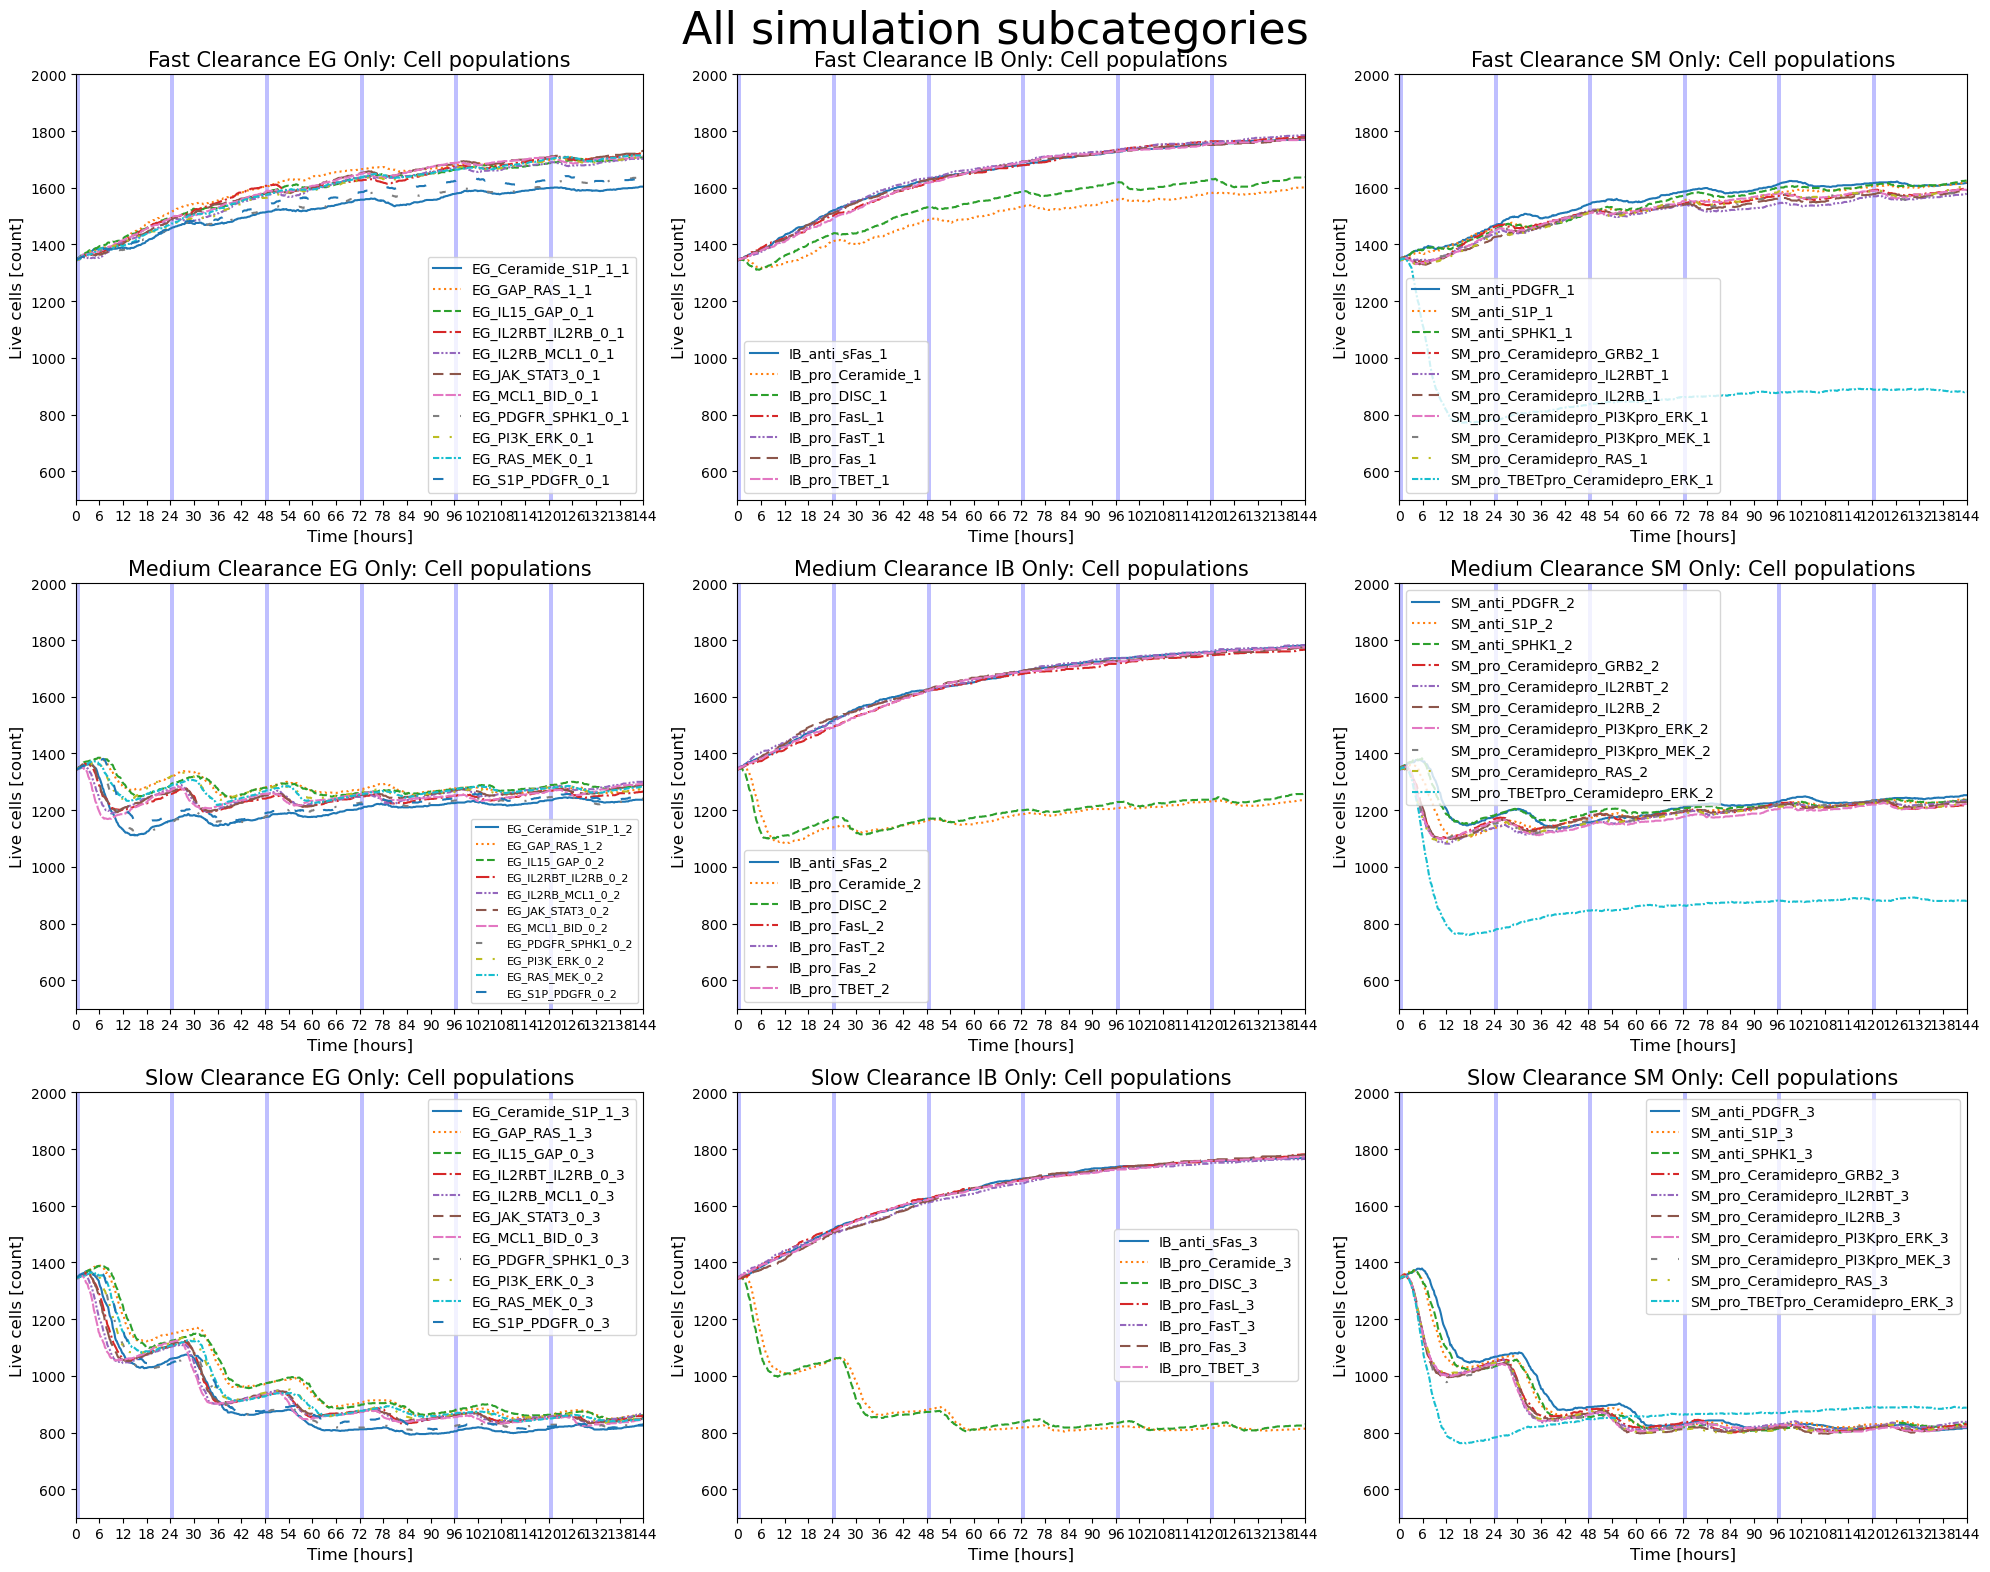

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(20, 16))

for category_name, ax in zip(individual_categories, axes.ravel(order='F')):    
    ax = plot_category_array(category_name, individual_categories[category_name], df, ax)

fig.suptitle('All simulation subcategories', fontsize=32)
plt.tight_layout()
plt.savefig('../figures/all_simulation_subcategories_space_and_time.png', dpi=600)
plt.show()

### Focusing on select time courses with emergent or unexpected out comes

In the middle column, the lower time courses switch rankings. Initially, pro_Ceramide experiences a a higher population decline than pro_DISC. However, by the 4th pulse of the pro-apoptoic substrate, the pro-DISC intervention becomes less effective (higher population). We see this at each level of clearance. Additionally, there is a similar shifting in the edgetic interventions - for exmaple, MCL1_BID_0 is initially more effective than Ceramide_S1P_1 - but ends at a higher value. 

This surprising result, which is due in part to accounting for the time that the interventions take to induce apoptosis, is not observable in a typical BN simulation. In addiiton to accounting for internal timing of the cellular decision process (including the recovery from a partial apoptotic state), these simulations can take into account that an apoptotic cell would actually die (and that it would take some real time to do that and for the cell to recover if it doenst’ die), that single cell-analyses miss. This can lead to population effects, such as a cumulative advantage that can be gained by faster recovery from a partial pro-apopotic state. (would we want to show that in MaBoSS? Can we soften this claim while still making the point?)

Lets pull out just these simulations - we will select the middle clearance,

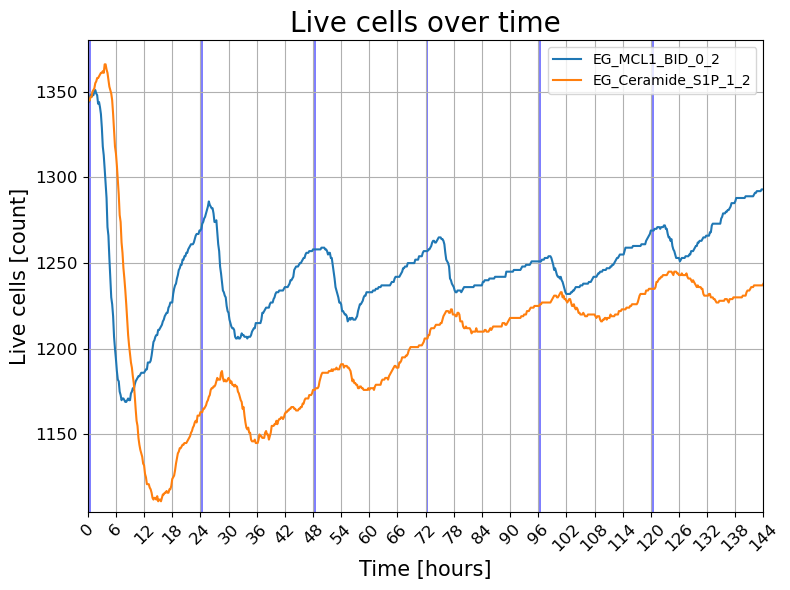

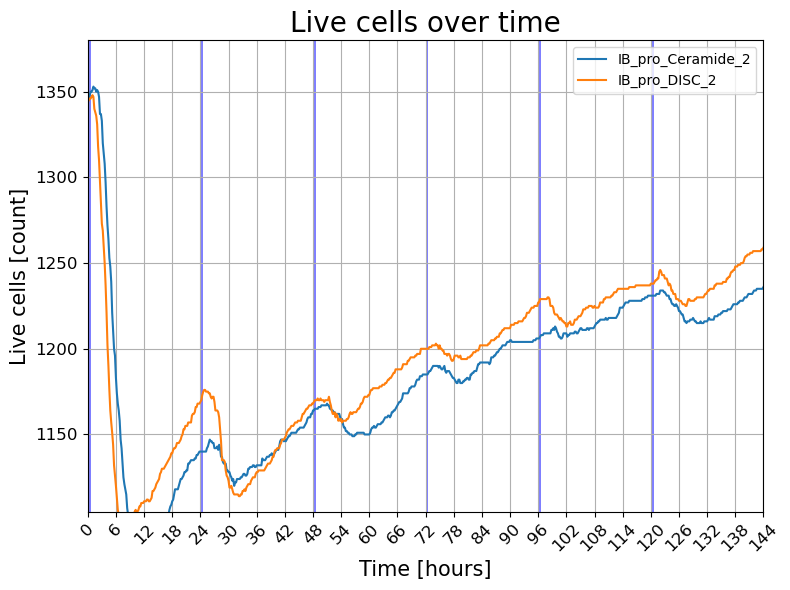

In [14]:
# plot just MCL1_BID_0, Ceramid_S1P_1, pro_Ceramide, and pro_DISC - from the original dataframe. 

focus_list = ['EG_MCL1_BID_0_2', 'EG_Ceramide_S1P_1_2', 'IB_pro_Ceramide_2', 'IB_pro_DISC_2']
focus_list = ['EG_MCL1_BID_0_2', 'EG_Ceramide_S1P_1_2']
focus_list_2 = ['IB_pro_Ceramide_2', 'IB_pro_DISC_2']
# linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
fig, ax = plt.subplots(figsize=(8, 6))
# for intervention, linestyle in zip(focus_list, linestyles):
#     plt.plot(df.index, df[intervention], linestyle=linestyle, label=intervention)

for intervention in focus_list:
    plt.plot(df.index, df[intervention],  label=intervention)
plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
plt.xlim(0, df.index[-1])
plt.ylim(1105, 1380)
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

# put these in a loop to color code the different time periods - every 24 hours.
for tick in ticks[0::4]:
    plt.axvspan(tick, tick+3, facecolor='blue', alpha=0.5, linewidth=6)

plt.legend()
plt.tight_layout()
plt.savefig('../figures/focus_interventions_space_and_time_EG.png', dpi=600)
plt.show()

### Second plot - the other two interventions.
fig, ax = plt.subplots(figsize=(8, 6))
for intervention in focus_list_2:
    plt.plot(df.index, df[intervention],  label=intervention)
plt.title('Live cells over time', fontsize=20)
plt.xlabel('Time [hours]', fontsize=15)
plt.ylabel('Live cells [count]', fontsize=15)
plt.xlim(0, df.index[-1])
plt.ylim(1105, 1380)
ticks = np.arange(0, len(df.index), 30)
plt.xticks(ticks, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', which='both')
# Use set_major_formatter to format ticks as hours

def fmt_index_to_hours(x, pos):
    x = x / 5  # 1/5 of an hour OR 12 minutes per index
    return f'{x:.0f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_index_to_hours))

# put these in a loop to color code the different time periods - every 24 hours.
for tick in ticks[0::4]:
    plt.axvspan(tick, tick+3, facecolor='blue', alpha=0.5, linewidth=6)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/focus_interventions_space_and_time_IB.png', dpi=600)
